## MountainCar with TileCoding
**Use tile coding to constuct the feature vector ${\Phi}(x,u)$**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from tqdm import tqdm
from math import floor

### Mountain Car
https://www.gymlibrary.dev/environments/classic_control/mountain_car/ <br>
<img src="https://www.gymlibrary.dev/_images/mountain_car.gif" alt="Mountain Car"/>

### Tile coding
<img src="sut_tile_fig9-9.png" alt="Tile coding"/>

In [2]:
class IHT:
    "Structure to handle collisions"
    def __init__(self, size_val):
        self.size = size_val
        self.overfull_count = 0
        self.dictionary = {}

    def count(self):
        return len(self.dictionary)

    def full(self):
        return len(self.dictionary) >= self.size

    def get_index(self, obj, read_only=False):
        d = self.dictionary
        if obj in d:
            return d[obj]
        elif read_only:
            return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfull_count == 0: print('IHT full, starting to allow collisions')
            self.overfull_count += 1
            return hash(obj) % self.size
        else:
            d[obj] = count
            return count

In [3]:
def hash_coords(coordinates, m, read_only=False):
    if isinstance(m, IHT): return m.get_index(tuple(coordinates), read_only)
    if isinstance(m, int): return hash(tuple(coordinates)) % m
    if m is None: return coordinates

In [4]:
def tiles(iht_or_size, num_tilings, floats, ints=None, read_only=False):
    if ints is None:
        ints = []
    qfloats = [floor(f * num_tilings) for f in floats]
    tiles = []
    for tiling in range(num_tilings):
        tilingX2 = tiling * 2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append((q + b) // num_tilings)
            b += tilingX2
        coords.extend(ints)
        tiles.append(hash_coords(coords, iht_or_size, read_only))
    return tiles

In [5]:
class ValueFunction:
    def __init__(self, step_size, num_of_tilings=8, max_size=2048):
        self.max_size = max_size
        self.num_of_tilings = num_of_tilings
        self.step_size = step_size / num_of_tilings
        self.hash_table = IHT(max_size)
        self.weights = np.zeros(max_size)
        
        # Get environment bounds
        env = gym.make('MountainCar-v0')
        self.position_scale = self.num_of_tilings / (env.observation_space.high[0] - env.observation_space.low[0])
        self.velocity_scale = self.num_of_tilings / (env.observation_space.high[1] - env.observation_space.low[1])

    def get_active_tiles(self, position, velocity, action):
        active_tiles = tiles(self.hash_table, self.num_of_tilings,
                            [self.position_scale * position, self.velocity_scale * velocity],
                            [action])
        return active_tiles

    def value(self, position, velocity, action):
        active_tiles = self.get_active_tiles(position, velocity, action)
        return np.sum(self.weights[active_tiles])

    def learn(self, position, velocity, action, target):
        active_tiles = self.get_active_tiles(position, velocity, action)
        estimation = np.sum(self.weights[active_tiles])
        delta = self.step_size * (target - estimation)
        for active_tile in active_tiles:
            self.weights[active_tile] += delta
        return estimation

### Getting started with tile coding
http://incompleteideas.net/tiles/tiles3.html

In [6]:
value_function = ValueFunction(step_size=0.1, num_of_tilings=8, max_size=1024)

# Example state
position = 3.6
velocity = 7.21
action = 1

active_tiles = value_function.get_active_tiles(position, velocity, action)
print(f"Active tiles: {active_tiles}")

Active tiles: [0, 1, 2, 3, 4, 5, 6, 7]


In [7]:
active_tiles = value_function.get_active_tiles(3.55, velocity, action)
print(f"Active tiles: {active_tiles}")

Active tiles: [0, 8, 2, 3, 4, 5, 6, 7]


## Q-learning
**Use optimistic initial values ($\epsilon=0$).** <br>
**$\gamma=1$**

In [8]:
def q_learning(value_function, num_episodes, gamma=1, epsilon=0):
    episode_rewards = []
    mse_history = []
    
    for episode in tqdm(range(num_episodes)):
        state, _ = env.reset()
        total_reward = 0
        timesteps = 0
        episode_mse = []
        done = False
        
        while not done:
            timesteps += 1
            position, velocity = state
            
            # Epsilon-greedy
            if np.random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_values = [value_function.value(position, velocity, a) for a in range(env.action_space.n)]
                action = np.argmax(q_values)
            
            # Take action
            next_state, reward, done, _, _ = env.step(action)
            next_position, next_velocity = next_state
            
            # Q-learning update
            next_q_values = [value_function.value(next_position, next_velocity, a) 
                           for a in range(env.action_space.n)]
            target = reward + gamma * max(next_q_values) if not done else reward
            
            estimation = value_function.learn(position, velocity, action, target)
            total_reward += reward
            state = next_state

            if timesteps >= env.spec.max_episode_steps:  # Check for max steps
                done = True
            
        episode_rewards.append(total_reward)
        
    return episode_rewards

In [9]:
env = gym.make('MountainCar-v0')

lr = 0.5
value_function = ValueFunction(step_size=lr)
rewards = q_learning(value_function, num_episodes=500)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:13<00:00, 37.84it/s]


## Plot learning curve

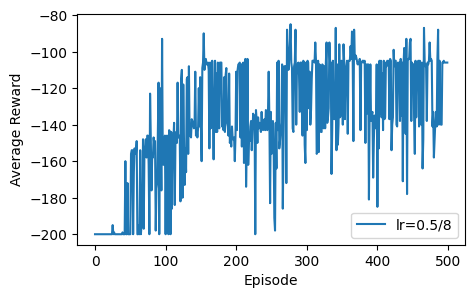

In [10]:
# Plot average rewards
plt.figure(figsize=(5, 3))
plt.plot(rewards, label=f'lr={lr}/{value_function.num_of_tilings}')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()
plt.show()

> **TODO:**
> - Try removing max step per episode
> - Try 3 different learning rates
> - Try different tilings

## Visualization

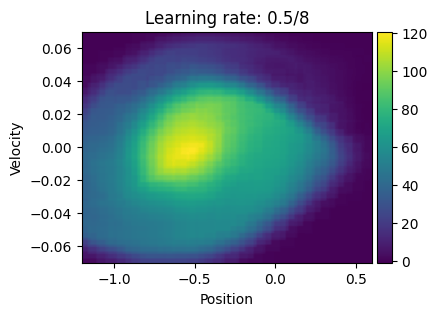

In [11]:
def plot_value_function(value_function, lr):
    # TODO
    raise NotImplementedError

plot_value_function(value_function, lr)

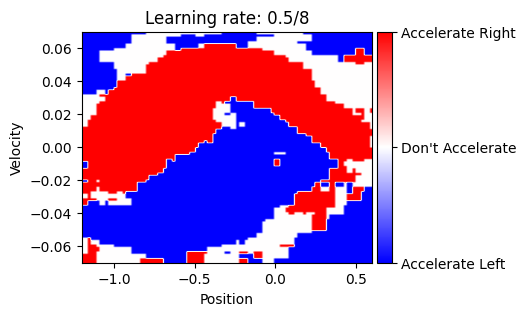

In [12]:
def plot_policy(value_function, lr:
    # TODO
    raise NotImplementedError

plot_policy(value_function, lr)